In [1]:
%load_ext autoreload

In [2]:
# Keep h5py deprecation warning off
import warnings

warnings.filterwarnings("ignore")

import argparse
import itertools
import json
import os
import pickle
import sys
import time

import h5py
import numpy as np
import openfermion
import scipy
from mpi4py import MPI

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()


def prints(text):
    global rank
    if rank == 0:
        print(text)

# from openfermion.transforms import normal_ordered
from openfermion import (
    get_fermion_operator,
    get_sparse_operator,
    hermitian_conjugated,
    normal_ordered,
)
from openfermion.ops import FermionOperator
from pyscf import mp, scf
from scipy import linalg as LA

import sys

sys.path.append("./tools")
from general_active_space import get_molecular_hamiltonian_generalAS

from molecule_object import (
    build_molecule,
    get_BeH2_object,
    get_H2O_object,
    get_LiH_object,
    get_N2_object,
)

from virtual_subspace_fermion import (
    generate_fermionic_excitation_terms,
    get_character_table,
    get_irrep_group,
)

In [5]:
import json
molecule_type = "LiH"
L = 1.2
basis_type = "sto-6g"
#rad = 2 * np.pi * degree / 360

nf = 0
spin = 0
occ_inds = list(range(nf))
orbital_type = "molecular"

n_qubit = 12

# This defines the active space of hamiltonian
occ_inds = []
if molecule_type == "H2O" and n_qubit == 10:
    occ_inds = [0, 4]
elif molecule_type == "N2" and n_qubit == 16:
    occ_inds = [0, 1]
elif molecule_type == "C2" and n_qubit == 16:
    occ_inds = [0, 1]

prints("\n======== system setup for 1st QSE loop =========")
prints("molecule type = %s" % molecule_type)
prints("basis = %s" % basis_type)
prints("L = %.5f" % L)
prints("")
prints("spin = %d" % spin)
prints("nf = %s" % (str(nf)))
prints("orbital_type=%s" % orbital_type)
#prints("use_cc_based_partition=%s" % use_cc_based_partition)
prints("==================================================\n\n")


# mean-field calculation to construct Hamiltonian
def scf_calculation(mol, irrep_nelec=None, dm0=None):

    if mol.spin == 0:
        mf = scf.RHF(mol)
    else:
        mf = scf.ROHF(mol)

    if irrep_nelec is not None:
        mf.irrep_nelec = irrep_nelec
    mf = scf.newton(mf)
    EHF = mf.kernel(dm0=dm0)
    a = mf.stability()[0]
    EHF = mf.kernel(mf.make_rdm1(a, mf.mo_occ))
    mf.stability()
    mf.analyze()
    return mf, EHF


# Needed for transformation into natural orbital
def compute_natural_orbitals(mf, mp2_solver):

    rho = mp2_solver.make_rdm1()
    if isinstance(rho, tuple):
        rho = rho[0] + rho[1]
    nat_occ, nat_orb = LA.eigh(-rho)
    nat_occ = -nat_occ
    return np.dot(mf.mo_coeff, nat_orb)


======== system setup for 1st QSE loop =========
molecule type = LiH
basis = sto-6g
L = 1.20000

spin = 0
nf = 0
orbital_type=molecular




In [6]:
##############################################################
# Building molecule object
##############################################################
# MolecularData: openfermion object
prints("\n\n==================================================")
prints("Building molecule...")
prints("==================================================\n\n")

t0 = time.time()
mol = build_molecule(molecule_type, basis_type, L=L, spin=spin)

if spin == 0:
    mf = scf.RHF(mol)
else:
    mf = scf.ROHF(mol)
mf.run()
EHF = mf.e_tot
t_molbuild = time.time() - t0
prints("...done in %.5f sec." % t_molbuild)

if orbital_type == "natural":
    mymp = mp.MP2(mf, frozen=occ_inds)
    mf.mo_coeff = compute_natural_orbitals(mf, mymp)

n_orb = mol.nao
# act_inds = list(set(range(n_orb)) - set(occ_inds))
act_inds = sorted(list(set(range(n_orb)) - set(occ_inds)))
n_qubit = 2 * len(act_inds)


symmetry_type = mol.symmetry
groups = get_irrep_group(mol, symmetry_type, act_inds, mf=mf)
characters = get_character_table(symmetry_type, mol=mol)

print("irrep groups")
print(groups)

print("\ncharacters")
print(groups)



Building molecule...


converged SCF energy = -7.92633755325148
...done in 0.18131 sec.
irrep groups
[[0, 1, 2, 3, 4, 5, 10, 11], [], [6, 7], [8, 9]]

characters
[[0, 1, 2, 3, 4, 5, 10, 11], [], [6, 7], [8, 9]]


In [7]:
##############################################################
# Build fermionic Hamiltonian
##############################################################

prints("\n\n==================================================")
prints("generating Fermionic Hamiltonian...")
prints("==================================================\n\n")

occupied_spinorbitals = sum([[2 * i, 2 * i + 1] for i in occ_inds], [])
active_spinorbitals = sum([[2 * i, 2 * i + 1] for i in act_inds], [])
t0 = time.time()
molecular_ham = get_molecular_hamiltonian_generalAS(
    mol, occupied_spinorbitals, active_spinorbitals, pyscf_mf=mf
)
# molecular_ham = molecule.get_molecular_hamiltonian(occ_inds, act_inds)
ham_f = get_fermion_operator(molecular_ham)



generating Fermionic Hamiltonian...




In [8]:
ham_f

1.3229430273 [] +
-4.882062865828659 [0^ 0] +
0.8303978068657155 [0^ 0^ 0 0] +
-0.06942784429613236 [0^ 0^ 0 2] +
-0.06818486205640432 [0^ 0^ 0 4] +
-0.00036105879648790085 [0^ 0^ 0 10] +
-0.06942784429613244 [0^ 0^ 2 0] +
0.010938954360794012 [0^ 0^ 2 2] +
0.006715394137983743 [0^ 0^ 2 4] +
-0.0013528533887800687 [0^ 0^ 2 10] +
-0.06818486205640434 [0^ 0^ 4 0] +
0.00671539413798373 [0^ 0^ 4 2] +
0.010978694447411797 [0^ 0^ 4 4] +
0.0015184280808400031 [0^ 0^ 4 10] +
0.0050389148653304915 [0^ 0^ 6 6] +
0.0050389148653304915 [0^ 0^ 8 8] +
-0.00036105879648802276 [0^ 0^ 10 0] +
-0.0013528533887800507 [0^ 0^ 10 2] +
0.0015184280808400242 [0^ 0^ 10 4] +
0.0016624073344821372 [0^ 0^ 10 10] +
0.8303978068657155 [0^ 1^ 1 0] +
-0.06942784429613236 [0^ 1^ 1 2] +
-0.06818486205640432 [0^ 1^ 1 4] +
-0.00036105879648790085 [0^ 1^ 1 10] +
-0.06942784429613244 [0^ 1^ 3 0] +
0.010938954360794012 [0^ 1^ 3 2] +
0.006715394137983743 [0^ 1^ 3 4] +
-0.0013528533887800687 [0^ 1^ 3 10] +
-0.0681848620564043

## create excitations by sorting according to amplitudes

In order to run the QSE, you need to feed
- number of single-body excitations (cdag c)
- number of two-body excitations (cdag cdag c c)
- Hartree-Fock bitstring

The former two values relies on molecules/systems, and you may need to explore to get precise choice.
Here we can fix these to be $n_{t1} = 5$ and $n_{t2} = 20$, while we may take larger $n_{t2}$ or even include three-body hoppings for correlated systems.

### Get Hartree-Fock state and its energy

In [9]:
from virtual_subspace_fermion import generate_hf_bitstring
hf_bitstring = generate_hf_bitstring(mol, act_spinorbitals=active_spinorbitals)
n_particle = hf_bitstring.count("1")

# sparse hamiltonian
ham_sp = get_sparse_operator(ham_f)

In [10]:
# extract hartree-fock energy
hf_energy = mf.e_tot
print("hf_energy = ", hf_energy)

# create Hartree-Fock state
hf_state = np.zeros(2**n_qubit)
hf_arg = int(hf_bitstring, base = 2)
hf_state[hf_arg] = 1.0

print(ham_sp[hf_arg, hf_arg])

hf_energy =  -7.926337553251476
(-7.926337553251474+0j)


In [11]:
vals, vecs = scipy.sparse.linalg.eigsh(ham_sp, which = "SA", k = 20)
fci_energy = np.min(vals)
print("fci_energy = ", fci_energy)

fci_energy =  -7.94319528045091


### Generate excitation terms
`generate_fermionic_excitation_terms` sort all the fermionic terms present in Hamiltonian according to their coefficients, and choose them from top. In the current setting, it is crutial to set `refer_to_HF = True` so that we don't choose meaningless terms that do not contribute to lower the energy.

In [13]:
n_term_t1 = 0
n_term_t2 = 20

In [14]:
from virtual_subspace_fermion import extract_hopping_matrix, extract_interaction_tensor, sort_terms_by_score
from virtual_subspace_fermion import generate_fermionic_excitation_terms

t1_terms, t1 = generate_fermionic_excitation_terms(
    ham_f, 
    hf_bitstring, 
    excitation_order=1,
    refer_to_HF=True, 
    n_term = n_term_t1,
    return_score_tensor = True
)

In [ ]:
for term in t1_terms:
    indices = [int(ind) if "^" not in ind else int(ind[:-1]) for ind in term.split(" ")]
    print(t1[indices[0]][indices[1]])

In [16]:
t2_terms, t2 = generate_fermionic_excitation_terms(
    ham_f, 
    hf_bitstring, 
    excitation_order=2,
    refer_to_HF=True, 
    n_term = n_term_t2,
    return_score_tensor = True,
)

In [17]:
t2_terms

['10^ 11^ 2 3',
 '5^ 10^ 2 3',
 '4^ 11^ 2 3',
 '8^ 9^ 2 3',
 '6^ 7^ 2 3',
 '4^ 5^ 0 1',
 '6^ 7^ 0 1',
 '8^ 9^ 0 1',
 '4^ 5^ 2 3',
 '8^ 9^ 0 3',
 '8^ 9^ 1 2',
 '6^ 7^ 1 2',
 '6^ 7^ 0 3',
 '5^ 11^ 1 3',
 '4^ 10^ 0 2',
 '4^ 11^ 0 3',
 '5^ 10^ 1 2',
 '10^ 11^ 0 3',
 '10^ 11^ 1 2',
 '10^ 11^ 0 1']

In [18]:
for term in t2_terms:
    indices = [int(ind) if "^" not in ind else int(ind[:-1]) for ind in term.split(" ")]
    print("\nindices = ", indices)
    print(f"t2[{indices[0]}, {indices[1]}, {indices[2]},{indices[3]}] = ", t2[indices[0]][indices[1]][indices[2]][indices[3]])
    print(f"t2[{indices[1]}, {indices[0]}, {indices[2]},{indices[3]}] = ", t2[indices[1]][indices[0]][indices[2]][indices[3]])
    #print(indices)
#print(t1[8, 2])
#print(t1[9, 3])
#print(t1[7, 5])


indices =  [10, 11, 2, 3]
t2[10, 11, 2,3] =  0.0
t2[11, 10, 2,3] =  0.061590386820329836

indices =  [5, 10, 2, 3]
t2[5, 10, 2,3] =  0.014933761334228482
t2[10, 5, 2,3] =  0.0

indices =  [4, 11, 2, 3]
t2[4, 11, 2,3] =  0.0
t2[11, 4, 2,3] =  0.014933761334228583

indices =  [8, 9, 2, 3]
t2[8, 9, 2,3] =  0.0
t2[9, 8, 2,3] =  0.012769268968826438

indices =  [6, 7, 2, 3]
t2[6, 7, 2,3] =  0.0
t2[7, 6, 2,3] =  0.012769268968826438

indices =  [4, 5, 0, 1]
t2[4, 5, 0,1] =  0.0
t2[5, 4, 0,1] =  0.010978694447411797

indices =  [6, 7, 0, 1]
t2[6, 7, 0,1] =  0.0
t2[7, 6, 0,1] =  0.0050389148653304915

indices =  [8, 9, 0, 1]
t2[8, 9, 0,1] =  0.0
t2[9, 8, 0,1] =  0.0050389148653304915

indices =  [4, 5, 2, 3]
t2[4, 5, 2,3] =  0.0
t2[5, 4, 2,3] =  0.00476504555482041

indices =  [8, 9, 0, 3]
t2[8, 9, 0,3] =  0.0
t2[9, 8, 0,3] =  0.00391661446636

indices =  [8, 9, 1, 2]
t2[8, 9, 1,2] =  0.00391661446636
t2[9, 8, 1,2] =  0.0

indices =  [6, 7, 1, 2]
t2[6, 7, 1,2] =  0.00391661446636
t2[7, 6, 1,2

In [19]:
# prepare excitation operators
P = [FermionOperator("")]
P += [FermionOperator(_term) for _term in t1_terms]
P += [FermionOperator(_term) for _term in t2_terms]
# P_sparse = [get_sparse_operator(_P, n_qubits = n_qubit) for _P in P]
dim = len(P)

In [20]:
P

[1.0 [],
 1.0 [10^ 11^ 2 3],
 1.0 [5^ 10^ 2 3],
 1.0 [4^ 11^ 2 3],
 1.0 [8^ 9^ 2 3],
 1.0 [6^ 7^ 2 3],
 1.0 [4^ 5^ 0 1],
 1.0 [6^ 7^ 0 1],
 1.0 [8^ 9^ 0 1],
 1.0 [4^ 5^ 2 3],
 1.0 [8^ 9^ 0 3],
 1.0 [8^ 9^ 1 2],
 1.0 [6^ 7^ 1 2],
 1.0 [6^ 7^ 0 3],
 1.0 [5^ 11^ 1 3],
 1.0 [4^ 10^ 0 2],
 1.0 [4^ 11^ 0 3],
 1.0 [5^ 10^ 1 2],
 1.0 [10^ 11^ 0 3],
 1.0 [10^ 11^ 1 2],
 1.0 [10^ 11^ 0 1]]

## Run quantum subspace expansion for hartree-fock state

In [21]:
def get_partial_matrix(mat, args):
    return np.copy(mat)[:, args][args, :]


def expectation(operator, state):
    if str(type(operator)).split(".")[0][8:] == "openfermion":
        n_qubit = int(np.log2(state.shape[0]))
        operator = get_sparse_operator(operator, n_qubits=n_qubit)
    if len(state.shape) == 1:
        return state.conj() @ operator @ state
    elif len(state.shape) == 2:
        return np.trace(operator @ state)

### fast way for classical simulation
we can use this to verify the effectiveness of couplers `P`

In [22]:
P_vec = [get_sparse_operator(_op, n_qubits = n_qubit) @ hf_state for _op in P]
hsub = np.zeros((dim ,dim), dtype = complex)
ssub = np.zeros((dim ,dim), dtype = complex)

for j in range(dim):
    for i in range(j+1):
        hsub[i, j] = P_vec[i].conj() @ ham_sp @ P_vec[j]
        ssub[i, j] = P_vec[i].conj() @ P_vec[j]
        
        if i !=j:
            hsub[j, i] = np.copy(hsub[i, j]).conj()
            ssub[j, i] = np.copy(ssub[i, j]).conj()
        

In [23]:
qse_en_array = []
for d in range(1, dim+1):
    h = get_partial_matrix(hsub, range(d))
    s = get_partial_matrix(ssub, range(d))
    ens = scipy.linalg.eigh(h, s)[0]
    qse_en_array.append(np.min(ens))
    #qse_energy = np.min(ens)
    

Text(0.5, 0, 'QSE dimension')

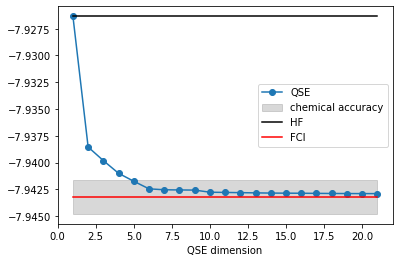

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

CHEM_ACC = 0.0016
dims = np.arange(1, dim + 1)
plt.plot(dims, qse_en_array, "-o", label = "QSE")
plt.fill_between(dims, y1 = fci_energy - CHEM_ACC, y2 = fci_energy + CHEM_ACC, color = "grey", alpha = 0.3, label = "chemical accuracy")
plt.plot(dims, [hf_energy]*len(qse_en_array), color = "black", label = "HF")
plt.plot(dims, [fci_energy]*len(qse_en_array), color = "red", label = "FCI")
plt.legend()
plt.xlabel("QSE dimension")

### Slow but real measurement-related computation

In [ ]:
hsub = np.zeros((dim ,dim), dtype = complex)
ssub = np.zeros((dim ,dim), dtype = complex)

for j in range(dim):
    h_Pj = ham_f * P[j]
    for i in range(j):
        h_ij = hermitian_conjugated(P[i]) * h_Pj
        s_ij = hermitian_conjugated(P[i]) * P[j]
        
        hsub[i, j] = expectation(h_ij, hf_state)
        ssub[i, j] = expectation(s_ij, hf_state)
        
        if i !=j:
            hsub[j, i] = np.copy(hsub[i, j]).conj()
            ssub[j, i] = np.copy(ssub[i, j]).conj()
        

In [23]:
qse_en_array = []
for d in range(1, dim+1):
    h = get_partial_matrix(hsub, range(d))
    s = get_partial_matrix(ssub, range(d))
    ens = scipy.linalg.eigh(h, s)[0]
    qse_en_array.append(np.min(ens))
    #qse_energy = np.min(ens)
    

Text(0.5, 0, 'QSE dimension')

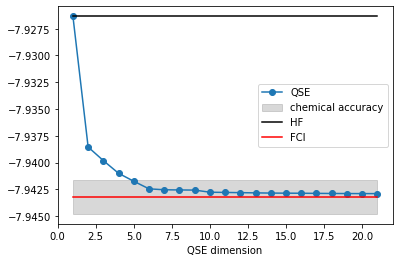

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

CHEM_ACC = 0.0016
dims = np.arange(1, dim + 1)
plt.plot(dims, qse_en_array, "-o", label = "QSE")
plt.fill_between(dims, y1 = fci_energy - CHEM_ACC, y2 = fci_energy + CHEM_ACC, color = "grey", alpha = 0.3, label = "chemical accuracy")
plt.plot(dims, [hf_energy]*len(qse_en_array), color = "black", label = "HF")
plt.plot(dims, [fci_energy]*len(qse_en_array), color = "red", label = "FCI")
plt.legend()
plt.xlabel("QSE dimension")